In [41]:
import keras
#from keras import Dense, Sequential, SGD, l2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
#from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
import numpy as np
from numpy import loadtxt
from keras import backend as K

from scikeras.wrappers import KerasRegressor
import time
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt

In [42]:
def read_tr(file_path, test_size=0.15, random_state=42):
    # load tr data
    train = loadtxt(file_path, delimiter=',', usecols=range(1, 14), dtype=np.float64)

    # Esclude la prima colonna e le ultime tre colonne (target)
    x = train[:, :-3]
    y = train[:, -3:]  # Le ultime tre colonne rappresentano i target

    # Suddivide il dataset in set di addestramento e test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    return x_train, y_train, x_test, y_test


def read_ts():
    file = "./cup/ds/ML-CUP23-TS.csv"
    test = loadtxt(file, delimiter=',', usecols=range(1, 11), dtype=np.float64)

    return test

def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
'''
def create_model(layers=3, n_units=30, init_mode='glorot_normal', activation='tanh', lmb=0.0001, eta=0.002, alpha=0.01, batch_size=None):
    model = Sequential()
    
    # create hidden layers
    for i in range(layers):
        # dense is for units fully connected 
        model.add(Dense(n_units, kernel_initializer=init_mode, activation=activation, kernel_regularizer=l1_l2(lmb))) 

    # create output layer with 3 neurons for x, y, z
    model.add(Dense(3, activation='linear', kernel_initializer=init_mode))
    
    # use SGD optimizer
    optimizer = SGD(learning_rate=eta, momentum=alpha)
    
    model.compile(optimizer=optimizer, loss=euclidean_distance_loss, metrics=[euclidean_distance_loss])  # Aggiunto metrics=[euclidean_distance_loss]
    
    return model


Best Parameters: {'alpha': 0.8, 'batch_size': 100, 'eta': 0.004, 'init_mode': 'glorot_normal', 'lmb': 0.005, 'n_units': 25}
Best Validation Loss: 2.98101544380188
Best Euclidean Distance Score: 1.5518332381772344

'''
def create_model(layers=3, n_units=200, init_mode='glorot_normal',activation='relu', lmb=0.005, eta=0.004, alpha=0.08, batch_size=None): #relu
    model = Sequential()
    
    # create hidden layers with tanh activation
    for i in range(layers - 1):  # Last layer will have ReLU activation
        model.add(Dense(n_units, kernel_initializer=init_mode, activation=activation, kernel_regularizer=l2(lmb)))
    
    # create output layer with linear activation
    model.add(Dense(3, kernel_initializer=init_mode, activation='linear'))

    # use SGD optimizer
    optimizer = SGD(learning_rate=eta, momentum=alpha)
    
    model.compile(optimizer=optimizer, loss=euclidean_distance_loss, metrics=[euclidean_distance_loss])
    
    return model


    
# it retrieves the mean value of all the passed losses
def euclidean_distance_score(y_true, y_pred):
    return np.mean(euclidean_distance_loss(y_true, y_pred))


scorer = make_scorer(euclidean_distance_score, greater_is_better=False)

In [43]:

from sklearn.model_selection import ParameterGrid

#params = dict(eta=0.004, alpha=0.8, lmb=0.005, epochs=250, batch_size=100)



'''
primo okk con l2

Best Parameters: {'alpha': 0.9, 'batch_size': 100, 'eta': 0.005, 'init_mode': 'glorot_normal', 'lmb': 0.0052, 'n_units': 25}
Best Validation Loss: 1.8620363473892212
Best Euclidean Distance Score: 1.1829318654716738

'''
'''
good stuff 
eta=0.004, alpha=0.8, lmb=0.0053, epochs=250, batch_size=120)
'''

def model_selection(x, y, epochs=200):
    param_grid = {
        'n_units': [300],
        'init_mode': ['glorot_normal'],
        #'activation': ['relu'],
        #'lmb': [0.0001,0.0005, 0.0008, 0.001]
        'lmb':[0.01, 0.1, 0.005, 0.01, 0.02, 0.001, 0.002, 0.003],
        'eta': [0.004, 0.005, 0.001],
        'alpha': [0.5, 0.8, 0.9],
        #'batch_size': [32, 64,100, 128]  # Aggiungi diverse dimensioni del batch
        'batch_size': [100,110,120]
    }

    param_combinations = list(ParameterGrid(param_grid))

    best_params = None
    best_loss = float('inf')  # Inizializza il miglior punteggio con un valore molto grande

    for params in param_combinations:
        # Crea e addestra il modello con gli iperparametri correnti
        model = create_model(layers=3, **params)
        history = model.fit(x, y, validation_split=0.3, epochs=epochs, batch_size=params['batch_size'], verbose=0)

        # Calcola la loss finale sul set di validazione
        val_loss = history.history['val_loss'][-1]

        # Calcola l'Euclidean Distance Loss
        val_score = euclidean_distance_score(y, model.predict(x))

        # Stampa euclidean_distance_loss e validation loss per ogni epoca
        print(f"\nParameters: {params}")
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs} - Euclidean Distance Loss: {history.history['euclidean_distance_loss'][epoch]:.4f} - Val Loss: {history.history['val_loss'][epoch]:.4f}")

        # Plot learning curve
        plot_learning_curve(history.history, epochs=epochs, start_epoch=1, **params)

        # Aggiorna il miglior punteggio e i relativi iperparametri se necessario
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
            best_score = val_score

    print("\nBest Parameters:", best_params)
    print("Best Validation Loss:", best_loss)
    print("Best Euclidean Distance Score:", best_score)

    return best_params
    


In [44]:
'''
# grid search parallelized
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid

def train_and_evaluate_model(params, x, y, epochs=1000):
    model = create_model(layers=3, **params)
    history = model.fit(x, y, validation_split=0.3, epochs=epochs, batch_size=params['batch_size'], verbose=0)
    
    val_loss = history.history['val_loss'][-1]
    val_score = euclidean_distance_score(y, model.predict(x))
    
    print(f"\nParameters: {params}")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs} - Euclidean Distance Loss: {history.history['euclidean_distance_loss'][epoch]:.4f} - Val Loss: {history.history['val_loss'][epoch]:.4f}")

    plot_learning_curve(history.history, epochs=epochs, start_epoch=1, **params)

    return params, val_loss, val_score, history.history

def model_selection(x, y, epochs=1000, n_jobs=-1):
    param_grid = {
        'n_units': [20, 30],
        'init_mode': ['glorot_normal'],
        'activation': ['tanh'],
        'lmb': [0.0001, 0.0005, 0.0008, 0.001, 0.005, 0.008, 0.01, 0.05, 0.08],
        'eta': [0.001, 0.002, 0.003],
        'alpha': [0.8, 0.9, 0.95],
        'batch_size': [100, 128]
    }

    param_combinations = list(ParameterGrid(param_grid))

    # Define the function to be parallelized
    def process_params(params):
        return train_and_evaluate_model(params, x, y, epochs)

    # Parallelize the grid search
    results = Parallel(n_jobs=n_jobs)(delayed(process_params)(params) for params in param_combinations)

    best_params, best_loss, best_score, best_history = min(results, key=lambda x: x[1])  # Assuming you're minimizing the loss

    print("\nBest Parameters:", best_params)
    print("Best Validation Loss:", best_loss)
    print("Best Euclidean Distance Score:", best_score)

    return best_params, best_history


'''


'\n# grid search parallelized\nfrom joblib import Parallel, delayed\nfrom sklearn.model_selection import ParameterGrid\n\ndef train_and_evaluate_model(params, x, y, epochs=1000):\n    model = create_model(layers=3, **params)\n    history = model.fit(x, y, validation_split=0.3, epochs=epochs, batch_size=params[\'batch_size\'], verbose=0)\n    \n    val_loss = history.history[\'val_loss\'][-1]\n    val_score = euclidean_distance_score(y, model.predict(x))\n    \n    print(f"\nParameters: {params}")\n    for epoch in range(epochs):\n        print(f"Epoch {epoch + 1}/{epochs} - Euclidean Distance Loss: {history.history[\'euclidean_distance_loss\'][epoch]:.4f} - Val Loss: {history.history[\'val_loss\'][epoch]:.4f}")\n\n    plot_learning_curve(history.history, epochs=epochs, start_epoch=1, **params)\n\n    return params, val_loss, val_score, history.history\n\ndef model_selection(x, y, epochs=1000, n_jobs=-1):\n    param_grid = {\n        \'n_units\': [20, 30],\n        \'init_mode\': [\'glo

In [45]:
def predict(model, x_ts, x_its, y_its):
    # predict on internal test set
    y_ipred = model.predict(x_its)
    _, iloss = model.evaluate(x_its, y_its, verbose=0)  # Utilizzo di evaluate invece di calcolare manualmente la loss

    # predict on blind test set
    y_pred = model.predict(x_ts)

    # return predicted target on blind test set,
    # and losses on internal test set
    return [y_pred[:, i] for i in range(y_pred.shape[1])], iloss
#y_pred sarà una matrice in cui ogni colonna rappresenta le previsioni per una delle tre variabili target. 
# La funzione restituirà quindi una lista di array, uno per ciascuna colonna.

In [46]:
def plot_learning_curve(history, start_epoch=1, **kwargs):
    lgd = ['Loss TR']
    plt.plot(range(start_epoch, kwargs['epochs']), history['loss'][start_epoch:])
    
    if "val_loss" in history:
        plt.plot(range(start_epoch, kwargs['epochs']), history['val_loss'][start_epoch:])
        lgd.append('Loss VL')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Keras Learning Curve \n {kwargs}')
    plt.legend(lgd)

    # Check if predictions are available in the history
    if 'predictions' in history:
        predictions = history['predictions']
        
        # Plot predictions for each variable
        for i in range(predictions.shape[1]):
            plt.figure()
            plt.plot(range(start_epoch, kwargs['epochs']), predictions[:, i][start_epoch:])
            plt.xlabel("Epoch")
            plt.ylabel(f"Prediction Variable {i+1}")
            plt.title(f'Keras Learning Curve \n {kwargs} - Prediction Variable {i+1}')
    
    plt.show()


In [47]:
def keras_nn(ms=False):
    print("keras start")

    file_path_tr = "./cup/ds/ML-CUP23-TR.csv"
    # read training set
    x, y, x_its, y_its = read_tr(file_path_tr)

    # choose model selection or hand-given parameters
    if ms:
        params = model_selection(x, y)
    else:
        params = dict(eta=0.00125, alpha=0.9, lmb=0.002, epochs=300, batch_size=110)
        #Parameters: {'activation': 'tanh', 'alpha': 0.9, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.001, 'n_units': 30}
        
        #Parameters: {'activation': 'tanh', 'alpha': 0.9, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.0001, 'n_units': 30}
#Best Parameters: {'activation': 'tanh', 'alpha': 0.9, 'eta': 0.003, 'init_mode': 'glorot_uniform', 'lmb': 0.0001, 'n_units': 30}

    # create and fit the model
    model = create_model(eta=params['eta'], alpha=params['alpha'], lmb=params['lmb'])
    res = model.fit(x, y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)

    tr_losses = res.history['loss']
    val_losses = res.history['val_loss']
    
    
  # Predict for the three variables
    y_pred, ts_losses = predict(model=model, x_ts=read_ts(), x_its=x_its, y_its=y_its)

    print("TR Loss: ", tr_losses[-1])
    print("VL Loss: ", val_losses[-1])
    print("TS Loss: ", np.mean(ts_losses))

# Extract predictions for each variable
    y_pred_x, y_pred_y, y_pred_z = y_pred

    print("Predictions for X: ", y_pred_x)  
    print("Predictions for Y: ", y_pred_y)
    print("Predictions for Z: ", y_pred_z)

    print("keras end")

    plot_learning_curve(res.history, savefig=True, **params)
    

keras start
Epoch 1/300


6/6 [==============================] - 0s 17ms/step - loss: 43.1433 - euclidean_distance_loss: 42.7035 - val_loss: 43.2252 - val_euclidean_distance_loss: 42.7854
Epoch 2/300
6/6 [==============================] - 0s 5ms/step - loss: 43.0685 - euclidean_distance_loss: 42.6288 - val_loss: 43.1157 - val_euclidean_distance_loss: 42.6760
Epoch 3/300
6/6 [==============================] - 0s 4ms/step - loss: 42.9487 - euclidean_distance_loss: 42.5091 - val_loss: 42.9731 - val_euclidean_distance_loss: 42.5335
Epoch 4/300
6/6 [==============================] - 0s 4ms/step - loss: 42.8012 - euclidean_distance_loss: 42.3617 - val_loss: 42.8103 - val_euclidean_distance_loss: 42.3709
Epoch 5/300
6/6 [==============================] - 0s 4ms/step - loss: 42.6368 - euclidean_distance_loss: 42.1973 - val_loss: 42.6307 - val_euclidean_distance_loss: 42.1913
Epoch 6/300
6/6 [==============================] - 0s 4ms/step - loss: 42.4572 - euclidean_distance_loss: 42.0177 - val_loss: 42.4330 - val_euclid

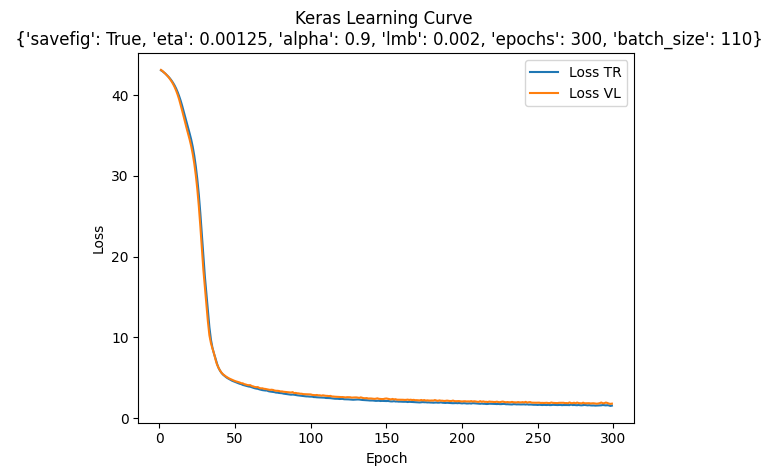

"\ngrid search params:     param_grid = {\n        'n_units': [30],\n        'init_mode': ['glorot_normal', 'glorot_uniform'],\n        'activation': ['tanh', 'sigmoid'],\n        'lmb': [0.0001, 0.001, 0.01],\n        'eta': [0.001, 0.002, 0.003],\n        'alpha': [0.5, 0.6, 0.7, 0.8, 0.9]\n    }\n\n    \nBest Parameters: {'alpha': 0.8, 'batch_size': 100, 'eta': 0.004, 'init_mode': 'glorot_normal', 'lmb': 0.005, 'n_units': 25}\nBest Validation Loss: 2.98101544380188\nBest Euclidean Distance Score: 1.5518332381772344\n"

In [48]:
keras_nn()